# Yelp Price Ratings - Affluence Prediction Model
### Britt Allen, Bernard Kurka, Thomas Ludlow - 1/9/2019

#### Libraries

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler, PowerTransformer, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

%matplotlib inline

#### Import Data
 - Yelp Training Data
 - IRS ZIP Data

In [99]:
zip_db = pd.read_csv('../Data/zip_code_database.csv')

In [102]:
zip_db[zip_db.state=='CT'].shape

(438, 15)

In [103]:
zip_db[zip_db.state=='NY'].shape

(2208, 15)

In [104]:
zip_db[zip_db.state=='RI'].shape

(91, 15)

In [ ]:
yelp_500 = pd.read_csv('../Data/api_data_501_1000.csv', dtype={'zip':str})

In [12]:
yelp = pd.read_csv('../Data/unravel_df.csv', dtype={'zip':str})

In [13]:
yelp.shape

(1000, 29)

In [3]:
yelp_500.head()

,zip,city,state,avg_lat,avg_long,rest_pr_1,rest_rv_1,rest_pr_2,rest_rv_2,rest_pr_3,...,shop_pr_4,shop_rv_4,loca_pr_1,loca_rv_1,loca_pr_2,loca_rv_2,loca_pr_3,loca_rv_3,loca_pr_4,loca_rv_4
0,65733,Protem,MO,36.501162,-92.804624,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,65768,Vanzant,MO,36.960000,-92.300000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,65772,Washburn,MO,36.587369,-93.964885,1,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,59001,Absarokee,MT,45.507814,-109.443925,1,8,1,8,0,...,0,0,0,0,0,0,0,0,0,0
4,59074,Ryegate,MT,46.390000,-109.380000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
yelp_500.columns

Index(['zip', 'city', 'state', 'avg_lat', 'avg_long', 'rest_pr_1', 'rest_rv_1',
       'rest_pr_2', 'rest_rv_2', 'rest_pr_3', 'rest_rv_3', 'rest_pr_4',
       'rest_rv_4', 'shop_pr_1', 'shop_rv_1', 'shop_pr_2', 'shop_rv_2',
       'shop_pr_3', 'shop_rv_3', 'shop_pr_4', 'shop_rv_4', 'loca_pr_1',
       'loca_rv_1', 'loca_pr_2', 'loca_rv_2', 'loca_pr_3', 'loca_rv_3',
       'loca_pr_4', 'loca_rv_4'],
      dtype='object')

In [5]:
irs = pd.read_csv('../final_irs_data.csv', index_col='Unnamed: 0', dtype={'zipcode':str})

In [6]:
irs.head()

,range_of_agi,num_of_returns,agi,taxable_pen_ann_amount,real_estate_tax_amount,pers_prop_tax_amount,net_invsmnt_inc_tax_amount,total_all_a_cols,total_chosen_a_cols,affluence,zipcode
0,1071,147025790,10250219281,684567013,195207458,9395550,16281907,43942839873,11155671209,75.875608,0
1,21,8980,506318,46469,10410,700,89,2027800,563986,62.804677,01001
2,21,9490,799175,86977,28269,795,913,3593345,916129,96.536249,01002
3,17,170,2435,0,0,0,0,6715,2435,14.323529,01003
4,21,2370,137832,11024,3010,192,0,548103,152058,64.159494,01005


In [7]:
irs.shape

(29874, 11)

In [14]:
df = yelp.merge(irs, how='left', left_on='zip', right_on='zipcode')

In [15]:
df.head()

,zip,city,state,avg_lat,avg_long,rest_pr_1,rest_rv_1,rest_pr_2,rest_rv_2,rest_pr_3,...,num_of_returns,agi,taxable_pen_ann_amount,real_estate_tax_amount,pers_prop_tax_amount,net_invsmnt_inc_tax_amount,total_all_a_cols,total_chosen_a_cols,affluence,zipcode
0,35016,Arab,AL,34.333496,-86.500985,4,19,7,55,0,...,7130,363111,45996,1352,297,61,1353497,410817,57.618093,35016
1,35071,Gardendale,AL,33.650618,-86.818072,11,99,10,275,0,...,7480,459107,42931,3303,674,107,1847517,506122,67.663369,35071
2,35210,Birmingham,AL,33.527970,-86.720594,25,549,5,255,0,...,6580,375294,29847,2652,540,350,1544135,408683,62.109878,35210
3,35674,Tuscumbia,AL,34.715455,-87.702378,8,77,2,34,0,...,7840,452481,43069,1297,321,76,1732701,497244,63.423980,35674
4,35677,Waterloo,AL,34.910000,-88.060000,0,0,0,0,0,...,720,30886,2545,46,15,0,104656,33492,46.516667,35677


In [95]:
irs.head()

,range_of_agi,num_of_returns,agi,taxable_pen_ann_amount,real_estate_tax_amount,pers_prop_tax_amount,net_invsmnt_inc_tax_amount,total_all_a_cols,total_chosen_a_cols,affluence,zipcode
0,1071,147025790,10250219281,684567013,195207458,9395550,16281907,43942839873,11155671209,75.875608,0
1,21,8980,506318,46469,10410,700,89,2027800,563986,62.804677,01001
2,21,9490,799175,86977,28269,795,913,3593345,916129,96.536249,01002
3,17,170,2435,0,0,0,0,6715,2435,14.323529,01003
4,21,2370,137832,11024,3010,192,0,548103,152058,64.159494,01005


In [16]:
df.shape

(1000, 40)

In [17]:
df[df.zip!=df.zipcode]

,zip,city,state,avg_lat,avg_long,rest_pr_1,rest_rv_1,rest_pr_2,rest_rv_2,rest_pr_3,...,num_of_returns,agi,taxable_pen_ann_amount,real_estate_tax_amount,pers_prop_tax_amount,net_invsmnt_inc_tax_amount,total_all_a_cols,total_chosen_a_cols,affluence,zipcode


In [18]:
df.columns

Index(['zip', 'city', 'state', 'avg_lat', 'avg_long', 'rest_pr_1', 'rest_rv_1',
       'rest_pr_2', 'rest_rv_2', 'rest_pr_3', 'rest_rv_3', 'rest_pr_4',
       'rest_rv_4', 'shop_pr_1', 'shop_rv_1', 'shop_pr_2', 'shop_rv_2',
       'shop_pr_3', 'shop_rv_3', 'shop_pr_4', 'shop_rv_4', 'loca_pr_1',
       'loca_rv_1', 'loca_pr_2', 'loca_rv_2', 'loca_pr_3', 'loca_rv_3',
       'loca_pr_4', 'loca_rv_4', 'range_of_agi', 'num_of_returns', 'agi',
       'taxable_pen_ann_amount', 'real_estate_tax_amount',
       'pers_prop_tax_amount', 'net_invsmnt_inc_tax_amount',
       'total_all_a_cols', 'total_chosen_a_cols', 'affluence', 'zipcode'],
      dtype='object')

In [19]:
df.drop(columns=['range_of_agi','zipcode'], inplace=True)

In [20]:
df.columns

Index(['zip', 'city', 'state', 'avg_lat', 'avg_long', 'rest_pr_1', 'rest_rv_1',
       'rest_pr_2', 'rest_rv_2', 'rest_pr_3', 'rest_rv_3', 'rest_pr_4',
       'rest_rv_4', 'shop_pr_1', 'shop_rv_1', 'shop_pr_2', 'shop_rv_2',
       'shop_pr_3', 'shop_rv_3', 'shop_pr_4', 'shop_rv_4', 'loca_pr_1',
       'loca_rv_1', 'loca_pr_2', 'loca_rv_2', 'loca_pr_3', 'loca_rv_3',
       'loca_pr_4', 'loca_rv_4', 'num_of_returns', 'agi',
       'taxable_pen_ann_amount', 'real_estate_tax_amount',
       'pers_prop_tax_amount', 'net_invsmnt_inc_tax_amount',
       'total_all_a_cols', 'total_chosen_a_cols', 'affluence'],
      dtype='object')

In [21]:
df.to_csv('df_190111.csv', index=False)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 38 columns):
zip                           1000 non-null object
city                          1000 non-null object
state                         1000 non-null object
avg_lat                       1000 non-null float64
avg_long                      1000 non-null float64
rest_pr_1                     1000 non-null int64
rest_rv_1                     1000 non-null int64
rest_pr_2                     1000 non-null int64
rest_rv_2                     1000 non-null int64
rest_pr_3                     1000 non-null int64
rest_rv_3                     1000 non-null int64
rest_pr_4                     1000 non-null int64
rest_rv_4                     1000 non-null int64
shop_pr_1                     1000 non-null int64
shop_rv_1                     1000 non-null int64
shop_pr_2                     1000 non-null int64
shop_rv_2                     1000 non-null int64
shop_pr_3                     1000 no

In [23]:
for i in range(1,5):
    col_pr_str = 'tot_pr_'+str(i)
    col_rv_str = 'tot_rv_'+str(i)
    df[col_pr_str] = sum([df['rest_pr_{}'.format(i)], df['shop_pr_{}'.format(i)], df['loca_pr_{}'.format(i)]])
    df[col_rv_str] = sum([df['rest_rv_{}'.format(i)], df['shop_rv_{}'.format(i)], df['loca_rv_{}'.format(i)]])

In [24]:
df['zero_check'] = df[['tot_pr_1','tot_rv_1', 'tot_pr_2','tot_rv_2', 'tot_pr_3', 
                       'tot_rv_3', 'tot_pr_4','tot_rv_4']].sum(axis=1)

In [25]:
df.zero_check.head()

0     91
1    454
2    998
3    150
4      0
Name: zero_check, dtype: int64

In [26]:
df.columns

Index(['zip', 'city', 'state', 'avg_lat', 'avg_long', 'rest_pr_1', 'rest_rv_1',
       'rest_pr_2', 'rest_rv_2', 'rest_pr_3', 'rest_rv_3', 'rest_pr_4',
       'rest_rv_4', 'shop_pr_1', 'shop_rv_1', 'shop_pr_2', 'shop_rv_2',
       'shop_pr_3', 'shop_rv_3', 'shop_pr_4', 'shop_rv_4', 'loca_pr_1',
       'loca_rv_1', 'loca_pr_2', 'loca_rv_2', 'loca_pr_3', 'loca_rv_3',
       'loca_pr_4', 'loca_rv_4', 'num_of_returns', 'agi',
       'taxable_pen_ann_amount', 'real_estate_tax_amount',
       'pers_prop_tax_amount', 'net_invsmnt_inc_tax_amount',
       'total_all_a_cols', 'total_chosen_a_cols', 'affluence', 'tot_pr_1',
       'tot_rv_1', 'tot_pr_2', 'tot_rv_2', 'tot_pr_3', 'tot_rv_3', 'tot_pr_4',
       'tot_rv_4', 'zero_check'],
      dtype='object')

In [63]:
df['pr_rv_1'] = df.tot_pr_1 * df.tot_rv_1
df['pr_rv_2'] = df.tot_pr_2 * df.tot_rv_2
df['pr_rv_3'] = df.tot_pr_3 * df.tot_rv_3
df['pr_rv_4'] = df.tot_pr_4 * df.tot_rv_4

In [64]:
df.head()

,zip,city,state,avg_lat,avg_long,rest_pr_1,rest_rv_1,rest_pr_2,rest_rv_2,rest_pr_3,...,tot_rv_2,tot_pr_3,tot_rv_3,tot_pr_4,tot_rv_4,zero_check,pr_rv_1,pr_rv_2,pr_rv_3,pr_rv_4
0,35016,Arab,AL,34.333496,-86.500985,4,19,7,55,0,...,56,0,0,0,0,91,126,448,0,0
1,35071,Gardendale,AL,33.650618,-86.818072,11,99,10,275,0,...,308,1,4,0,0,454,1284,6776,4,0
2,35210,Birmingham,AL,33.527970,-86.720594,25,549,5,255,0,...,314,2,15,0,0,998,19776,5338,30,0
3,35674,Tuscumbia,AL,34.715455,-87.702378,8,77,2,34,0,...,46,1,3,1,9,150,616,230,3,9
4,35677,Waterloo,AL,34.910000,-88.060000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [65]:
features = ['avg_lat', 'avg_long', 'pr_rv_1','pr_rv_2', 'pr_rv_3',
            'pr_rv_4']

X = df[df.zero_check>0][features]
y = np.log(df[df.zero_check>0]['affluence'])

In [66]:
X.head()

,avg_lat,avg_long,pr_rv_1,pr_rv_2,pr_rv_3,pr_rv_4
0,34.333496,-86.500985,126,448,0,0
1,33.650618,-86.818072,1284,6776,4,0
2,33.527970,-86.720594,19776,5338,30,0
3,34.715455,-87.702378,616,230,3,9
5,34.741496,-86.680809,52888,251251,7440,3


In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

In [68]:
X_train.shape

(519, 6)

In [69]:
X_test.shape

(173, 6)

In [70]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [71]:
lr.score(X_train, y_train)

0.08628527106099837

In [72]:
lr.score(X_test, y_test)

0.0787965609706317

In [73]:
cross_val_score(lr, X_train, y_train, cv=5)

array([ 0.03738084,  0.05790473, -0.29149279, -0.09981326,  0.11186651])

In [74]:
lasso = LassoCV(cv=5)
lasso.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [75]:
lasso.score(X_train, y_train)

0.042336525117954056

In [76]:
lasso.score(X_test, y_test)

0.061221470681876555

In [84]:
pipe = Pipeline(
    [('scaler', StandardScaler()),
    ('lasso', LassoCV())]
)

In [85]:
pipe.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lasso', LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False))])

In [86]:
pipe.score(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.07056610020792775

In [87]:
pipe.score(X_test, y_test)

/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


0.0710807521515553

In [88]:
cross_val_score(pipe, X_train, y_train, cv=5)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversion

array([ 0.04532045,  0.03798546, -0.00502687, -0.01884162,  0.06957266])

In [89]:
cross_val_score(pipe, X_test, y_test, cv=3)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:465: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, y, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/pipeline.py:511: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversion

array([0.10085451, 0.01806117, 0.0729043 ])

<Figure size 1440x1440 with 0 Axes>

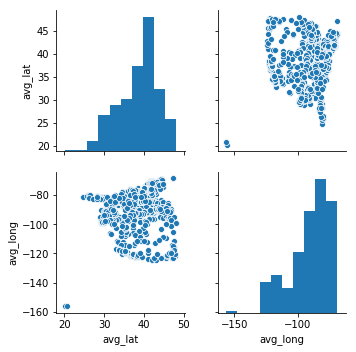

In [94]:
plt.figure(figsize=(20,20))
sns.pairplot(X.join(y)[['avg_lat','avg_long']])

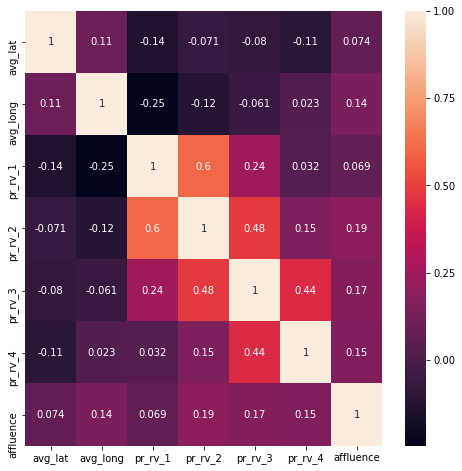

In [91]:
plt.figure(figsize=(8,8))
sns.heatmap(X.join(y).corr(), annot=True)

In [57]:
irs.head()

,range_of_agi,num_of_returns,agi,taxable_pen_ann_amount,real_estate_tax_amount,pers_prop_tax_amount,net_invsmnt_inc_tax_amount,total_all_a_cols,total_chosen_a_cols,affluence,zipcode
0,1071,147025790,10250219281,684567013,195207458,9395550,16281907,43942839873,11155671209,75.875608,0
1,21,8980,506318,46469,10410,700,89,2027800,563986,62.804677,01001
2,21,9490,799175,86977,28269,795,913,3593345,916129,96.536249,01002
3,17,170,2435,0,0,0,0,6715,2435,14.323529,01003
4,21,2370,137832,11024,3010,192,0,548103,152058,64.159494,01005


In [61]:
yelp_500[yelp_500.state=='NY']

,zip,city,state,avg_lat,avg_long,rest_pr_1,rest_rv_1,rest_pr_2,rest_rv_2,rest_pr_3,...,shop_pr_4,shop_rv_4,loca_pr_1,loca_rv_1,loca_pr_2,loca_rv_2,loca_pr_3,loca_rv_3,loca_pr_4,loca_rv_4
76,10035,New York,NY,40.800589,-73.939248,26,679,13,1168,0,...,1,1,2,12,2,22,0,0,0,0
77,10170,New York,NY,40.750000,-73.980000,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
78,10588,Shrub Oak,NY,41.329909,-73.824461,1,32,7,262,0,...,0,0,1,5,1,3,0,0,0,0
79,10709,Eastchester,NY,40.955366,-73.814165,3,93,10,1296,1,...,1,3,0,0,2,8,1,5,0,0
80,10917,Woodbury,NY,41.320803,-74.124551,11,157,12,777,0,...,13,47,0,0,0,0,0,0,0,0
81,10922,Fort Montgomery,NY,41.335335,-73.983107,0,0,2,195,0,...,0,0,0,0,0,0,0,0,0,0
82,10956,New City,NY,41.142791,-73.991308,15,455,36,2156,1,...,1,27,3,4,2,11,0,0,0,0
83,10962,Orangeburg,NY,41.047288,-73.949825,5,80,14,744,1,...,0,0,1,2,1,1,0,0,0,0
84,10987,Tuxedo Park,NY,41.193609,-74.192614,3,64,3,355,0,...,0,0,0,0,0,0,0,0,0,0
85,11215,Brooklyn,NY,40.668503,-73.984611,36,4104,44,8508,2,...,3,14,11,243,18,685,6,108,0,0
